In [1]:
import re
import string
import warnings
import datetime

import numpy as np
import pandas as pd

from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

warnings.filterwarnings('ignore')

-----------

In [2]:
df_sbuzz = pd.read_csv("syndata/Box Office/twitter_clean.csv")
df_title = pd.read_csv("syndata/Box Office/box_office_clean.csv")

In [3]:
movie_dict = {}
c = 0

for i in df_sbuzz.index:
    if df_sbuzz.at[i, 'title'] not in movie_dict:
        c+=1
        movie_dict[df_sbuzz.at[i, 'title']] = c

for i in df_title.index:
    if df_title.at[i, 'Title'] not in movie_dict:
        c+=1
        movie_dict[df_title.at[i, 'Title']] = c
        
rev_movie_dict = {v:k for k, v in movie_dict.items()}

In [4]:
titles = list(df_title['movie_id_t'].unique())
titles_buzz =  list(df_sbuzz['movie_id_s'].unique())
set_intersection_titles = list(set(titles).intersection(titles_buzz))

In [5]:
df_sbuzz['post_date'] = pd.to_datetime(df_sbuzz['post_date'])
df_title['begin_date'] = pd.to_datetime(df_title['begin_date'])
df_title['end_date'] = pd.to_datetime(df_title['end_date'])

In [6]:
# df_sbuzz.sample(2)

,ID,title,post_link,post_date_time,post_content,user_name,user_bio,user_followers_count,user_followee_count,user_post_count,country,state,language,post_date,post_time,movie_id_s,nth_week_number,is_influencer,tweet_sentiment
47515,9,dunkirk,http://twitter.com/aliciasparkss/status/885822...,2017-07-14T11:25:26.000+0000,RT @thestylespics Harry at the Dunkirk premier...,aliciasparkss,NaN,657,228,30918,AUS,New South Wales,en,2017-07-14,11:25:26,11.0,28.0,False,0.00
76621,21,occupation,http://twitter.com/kymbco/status/1070246996965...,2018-12-05T09:22:22.000+0000,"RT @benabyad Muhammad was shot in the leg, and...",kymbco,Old Aussie lawyer who tells it as I see it - n...,280,118,134721,AUS,NaN,en,2018-12-05,09:22:22,21.0,49.0,False,-0.93


In [7]:
# df_title.sample(2)

,Title,Date,Year,Rank,Weekend Gross,Gross-to-Date,Week # of release,begin_date,end_date,has_weekend,nth_week_number,movie_id_t,gross_to_date_float,weekend_gross_float
69,black panther,May 17–20,2018,35,"$4,659","$31,871,479",14,2018-05-17,2018-05-20,True,20.0,4.0,31871479.0,4659.0
57,black panther,Feb. 22–25,2018,1,"$5,888,647","$17,352,989",2,2018-02-22,2018-02-25,True,8.0,4.0,17352989.0,5888647.0


--------

In [8]:
plt.rcParams['figure.figsize'] = [16, 10]
sns.set(color_codes=True)

# Analysis through feature engineering and visualization

## Cumulative movie sales in the box office:

In [9]:
agg_cost = df_title.groupby(['Title']).sum()[['gross_to_date_float']].sort_values(
    by='gross_to_date_float', ascending=False)

In [10]:
weekend_to_total = df_title[['Title', 'weekend_gross_float', 'gross_to_date_float']]
weekend_to_total = weekend_to_total.fillna(0)

In [11]:
# weekend sales and gross total are negatively correlated
stats.spearmanr(weekend_to_total['weekend_gross_float'], weekend_to_total['gross_to_date_float'])

SpearmanrResult(correlation=-0.12802988502257107, pvalue=0.04187736925949874)

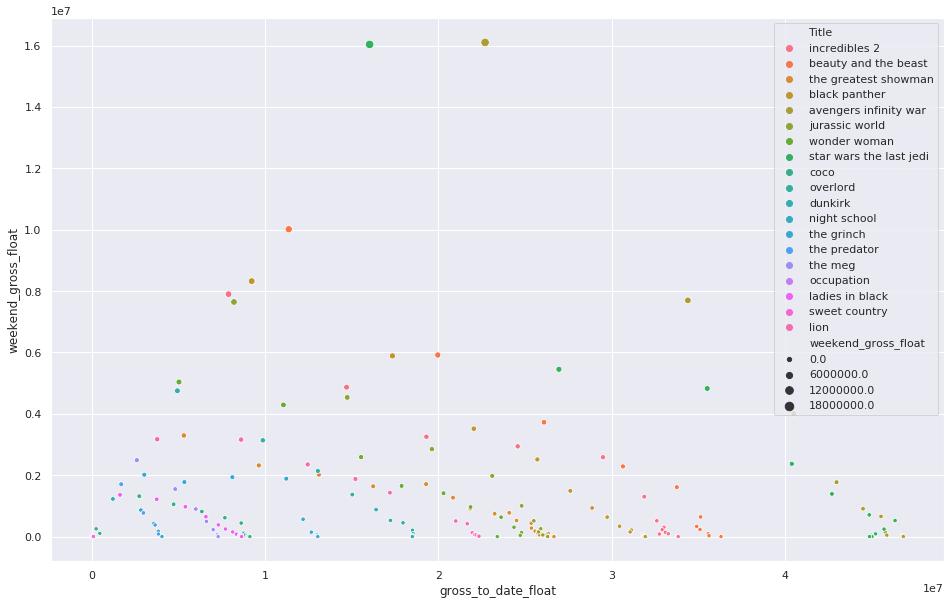

In [12]:
sns.scatterplot(data=weekend_to_total, hue = "Title", 
                y="weekend_gross_float", x="gross_to_date_float", 
                size="weekend_gross_float");

# weekend sales are initially high when the movie releases and 
# thereafter it starts declining while though total sales keeps increasing

## General Tweets Analysis

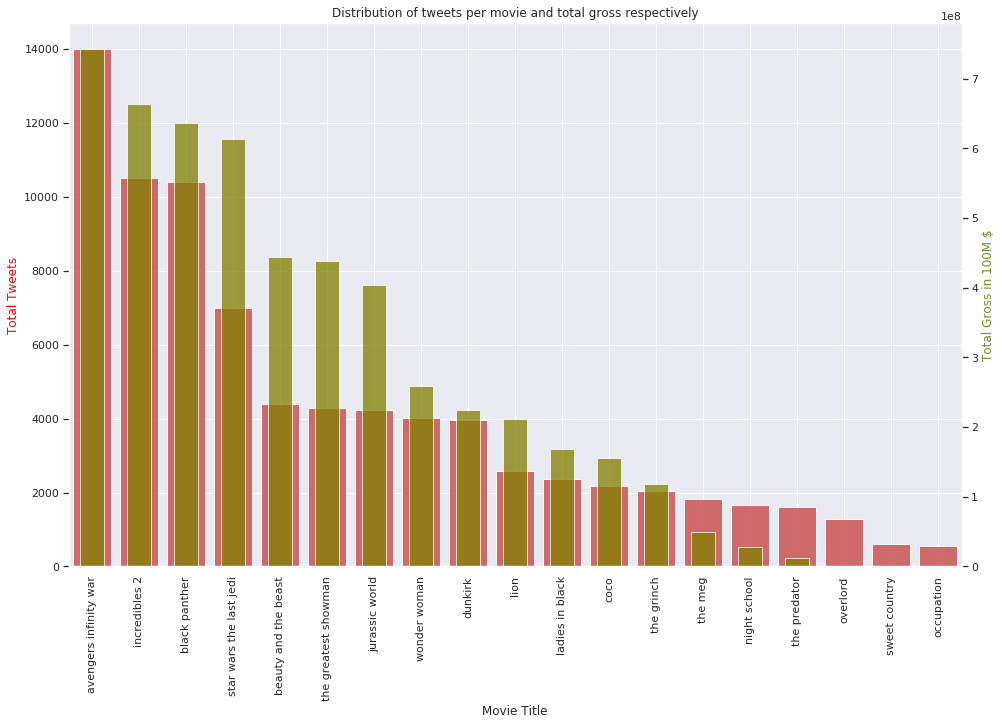

In [13]:
# distribution of tweets per movie and total gross respectively
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_title("Distribution of tweets per movie and total gross respectively")

df_sbuzz['title'].value_counts().plot(kind='bar', ax=ax, width=0.82, color='indianred', alpha=0.9);
ax.set_xlabel("Movie Title")
ax.set_ylabel("Total Tweets");
ax.yaxis.label.set_color('red')

ax2 = ax.twinx()

agg_cost.plot(kind='bar', legend=False, ax=ax2, color='olive', alpha=0.75)
ax2.set_xlabel("Movie Title")
ax2.set_ylabel("Total Gross in 100M $");
ax2.yaxis.label.set_color('olivedrab')
ax2.grid(False)

# for p in ax.patches:
#     ax.annotate(str(int(p.get_height())), (p.get_x()*1.004, p.get_height()*1.01), rotation=20)

### Sales distributed across weeks

In [14]:
by_week = (df_title
            .groupby(['Title', 'Week # of release'])
            .size()
            .unstack())

In [15]:
for idx in by_week.index:
    for col in by_week.columns:
        
        try:
            by_week.at[idx, col] = float(df_title[(df_title['Title']==idx) & (df_title['Week # of release']==col)]['gross_to_date_float'])
        except:
            by_week.at[idx, col] = np.nan


In [16]:
# by_week.sample(3)
# by_nth_week.sample(3)

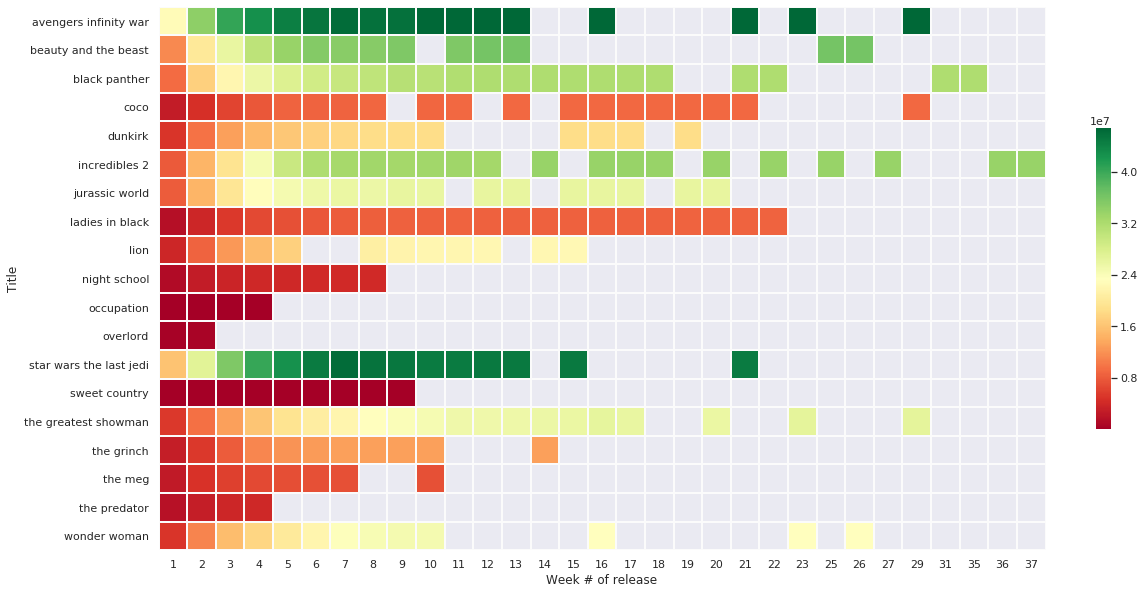

In [17]:
plt.figure(figsize=(18,10))
week_releases = sns.heatmap(
    by_week, 
    square=True, 
    cbar_kws={'fraction' : 0.015}, 
    cmap='RdYlGn',
    linewidth=1,
    linecolor="#fbfbfb"
)

# given box office sales for movies that have only performed good, i.e. sales keep increasing after every week

### Do tweets effect sales?

In [18]:
tweets_per_movie_date = df_sbuzz.groupby(['movie_id_s', 'title', 'post_date']).size().unstack(1)

In [19]:
box_vs_tweets = df_title[['movie_id_t', 'Title', 'Week # of release', 
                          'begin_date', 'end_date', 'gross_to_date_float', 'weekend_gross_float']]

In [20]:
box_vs_tweets["tweets_received"] = 0

In [21]:
for m_id, time in tweets_per_movie_date.index:
    curr_df = box_vs_tweets[box_vs_tweets['movie_id_t']==m_id]
    for idx in curr_df.index:
        
        if curr_df.at[idx, 'begin_date'] < time < curr_df.at[idx, 'end_date']:
            box_vs_tweets.at[idx, 'tweets_received'] = tweets_per_movie_date.loc[(m_id, time), rev_movie_dict[m_id]]

        if curr_df.at[idx, 'begin_date'] > time or curr_df.at[idx, 'begin_date'] < time:
            new_idx = len(box_vs_tweets)+1
            box_vs_tweets.at[new_idx, 'begin_date'] = time.date()
            box_vs_tweets.at[new_idx, 'end_date'] = time.date()
            box_vs_tweets.at[new_idx, 'Title'] = rev_movie_dict[m_id]
            box_vs_tweets.at[new_idx, 'movie_id_t'] = m_id
            box_vs_tweets.at[new_idx, 'tweets_received'] = tweets_per_movie_date.loc[(m_id, time), rev_movie_dict[m_id]]
        
    box_vs_tweets.drop_duplicates(inplace=True)

In [22]:
# tweets_per_movie_date

In [23]:
box_vs_tweets = (box_vs_tweets
                 .sort_values(by=['movie_id_t', 'begin_date'])
                 .reset_index()
                 .drop(axis=1, labels=['index'])
                 .fillna(0))

In [50]:
# box_vs_tweets.sort_values(by='tweets_received', ascending=False).head(10)

In [25]:
box_vs_tweets["rel_week_release"] = 0

for key in set_intersection_titles:
    d = box_vs_tweets[box_vs_tweets['movie_id_t']==key]
    
    # assuming first starts with 1st week of release by default

    indicator = 1
    first = list(d[d['Week # of release']==indicator]['begin_date'])[0]

    for ix in d.index:
        
        if d.at[ix, 'rel_week_release'] == 0:
                        
            if d.at[ix, 'begin_date'] == first:
                box_vs_tweets.at[ix, 'rel_week_release'] =  indicator

            elif d.at[ix, 'begin_date'] < first:
                delta_days = d.at[ix, 'begin_date'] - first
                box_vs_tweets.at[ix, 'rel_week_release'] =  (delta_days/7).days 

            elif d.at[ix, 'begin_date'] > first:
                delta_days = d.at[ix, 'begin_date'] - first
                box_vs_tweets.at[ix, 'rel_week_release'] =  (delta_days/7).days + 1

In [27]:
bvt = box_vs_tweets.drop(axis=1, labels=['Week # of release', 'begin_date', 'end_date'])

In [28]:
# bvt.sort_values(by='tweets_received', ascending=False).tail(20)

In [29]:
bvt2 = (bvt.groupby(['Title', 'rel_week_release'])['tweets_received'].sum().unstack(-1))

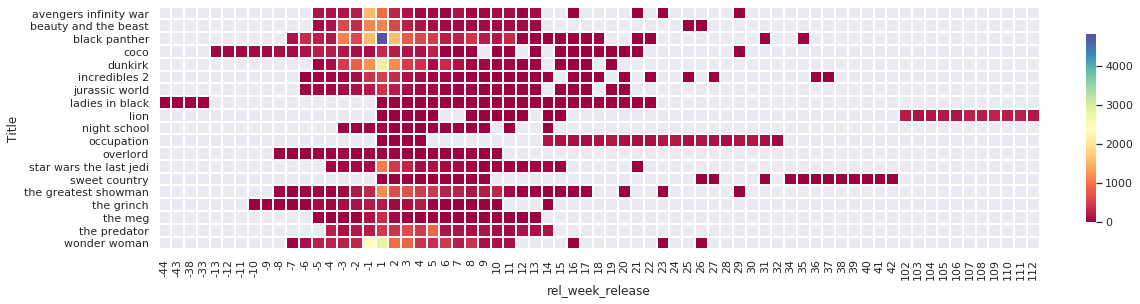

In [30]:
# number of tweets varying as weeks progress in the box office
qwt = sns.heatmap(
    bvt2, 
    square=True, 
    cbar_kws={'fraction' : 0.01}, 
    cmap='Spectral',
    linewidth=1 
);
plt.tight_layout()

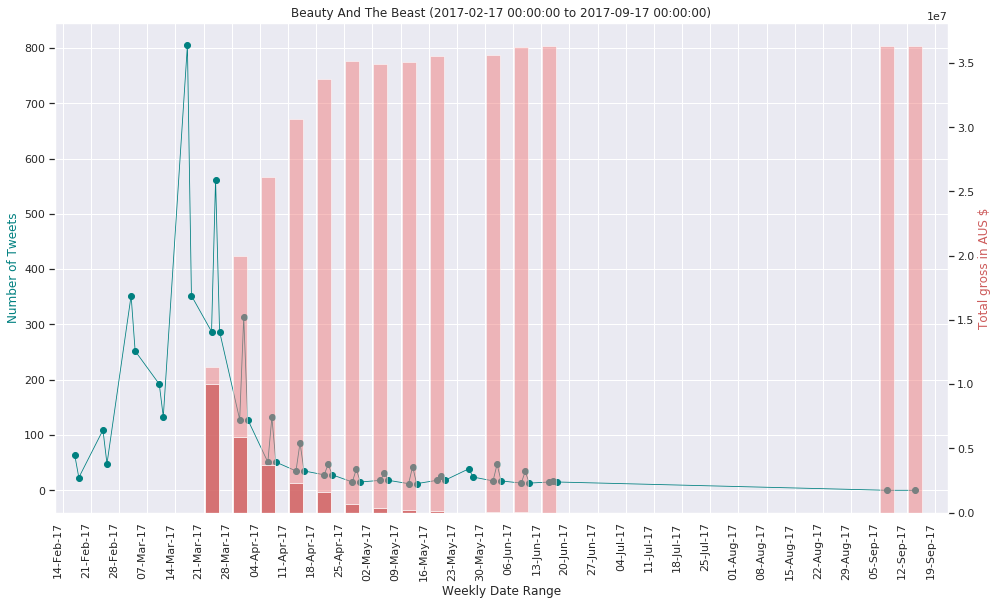

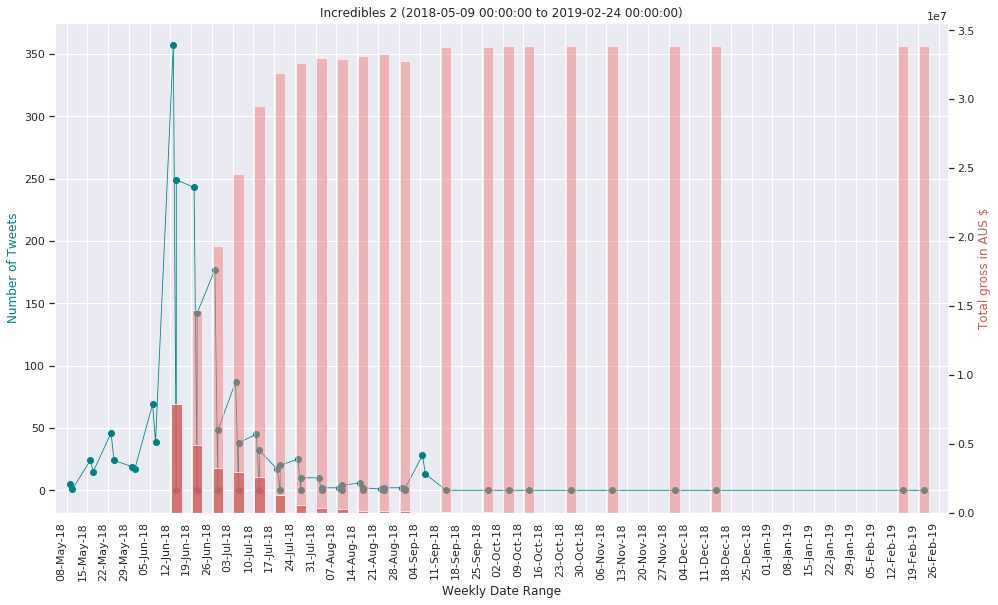

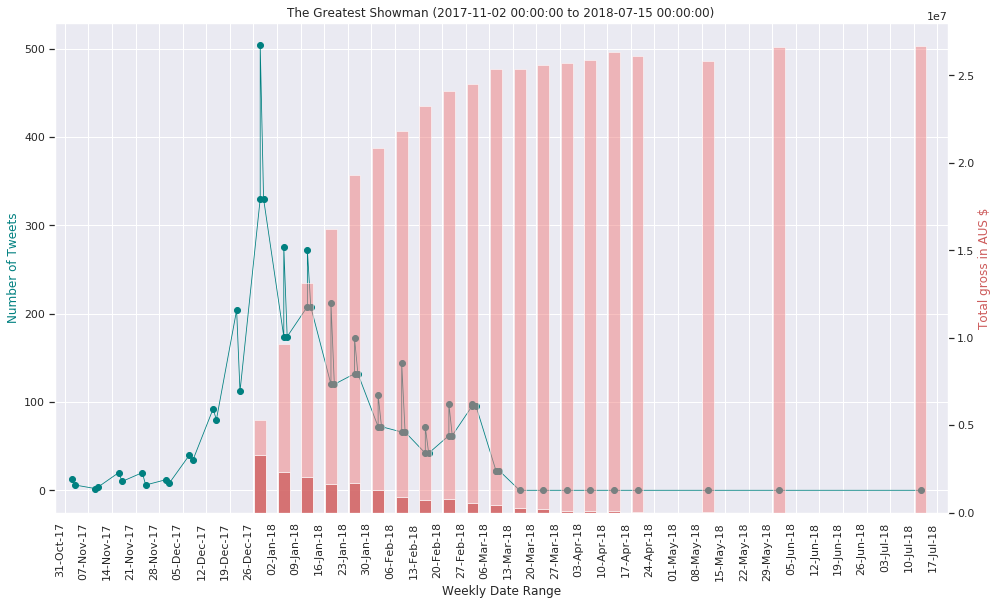

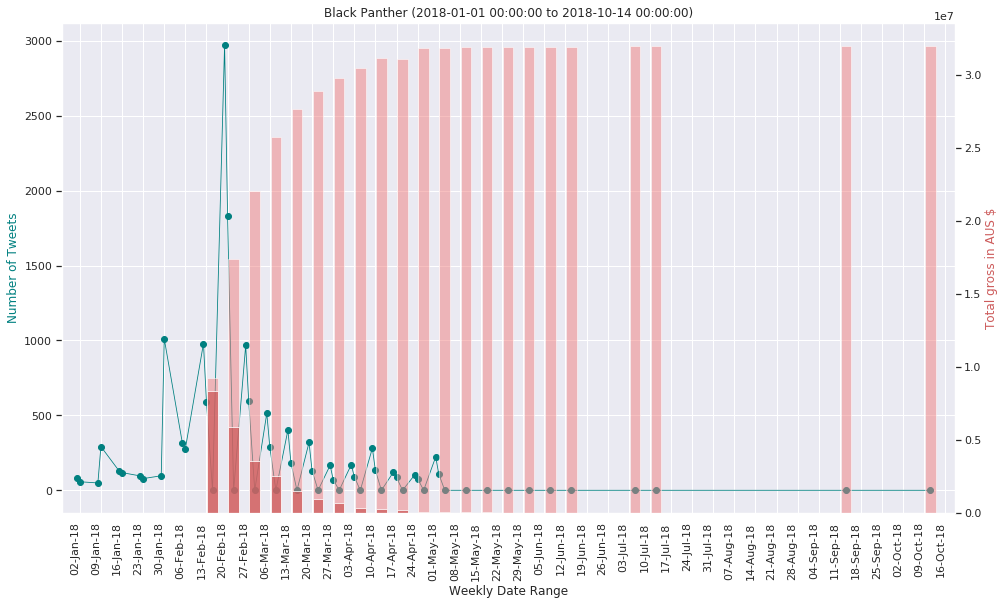

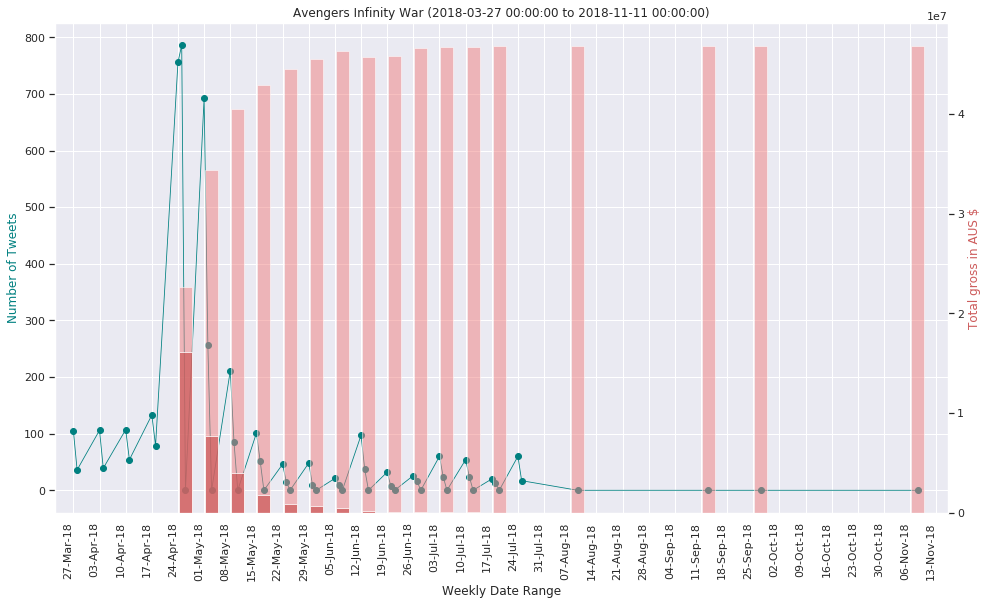

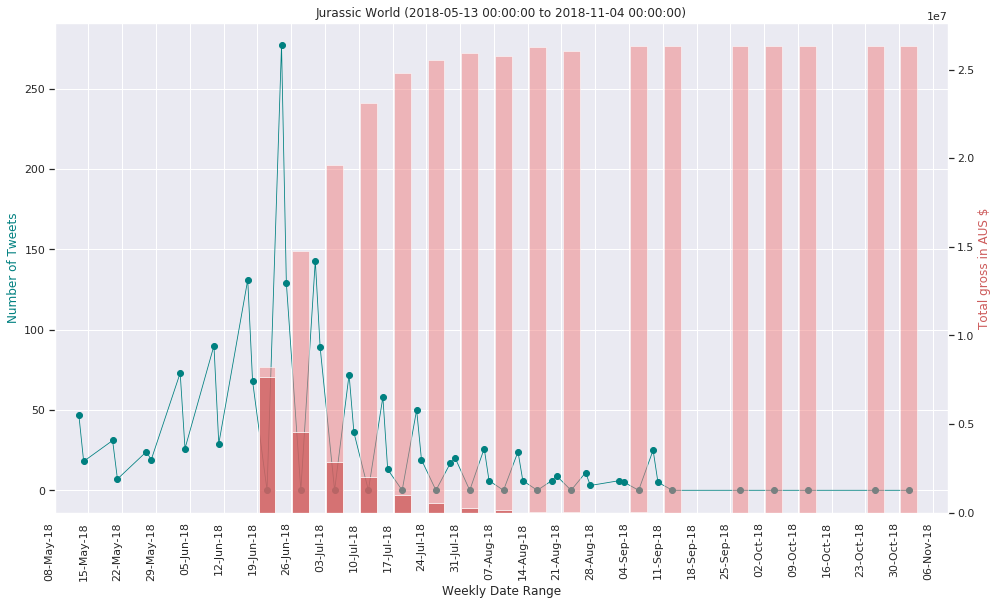

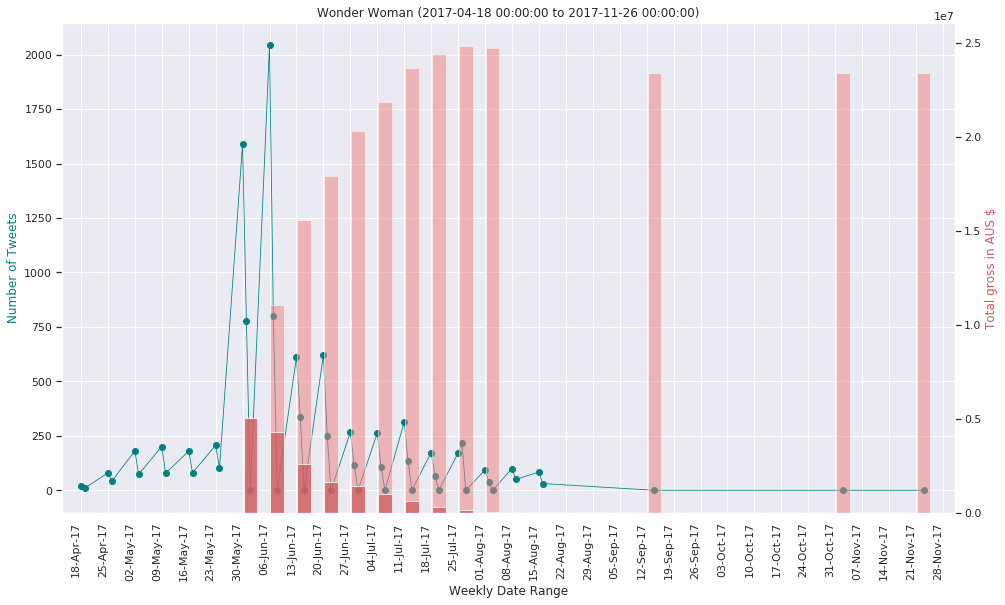

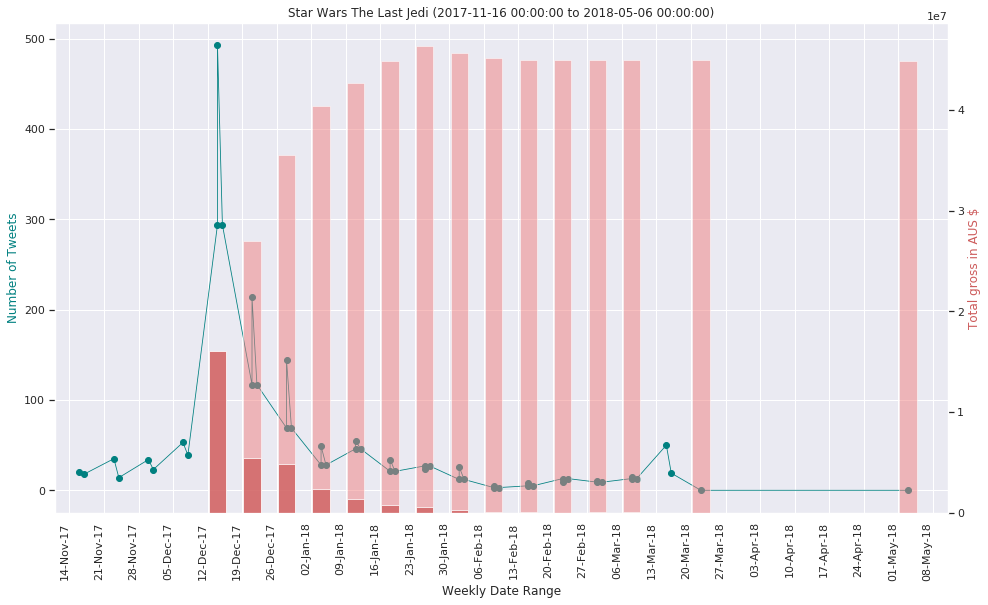

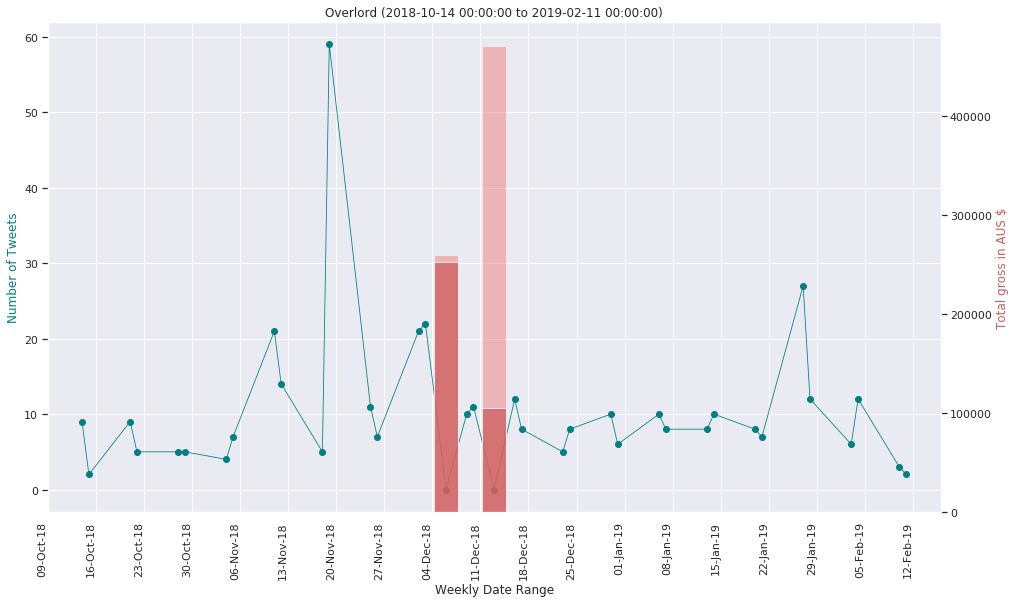

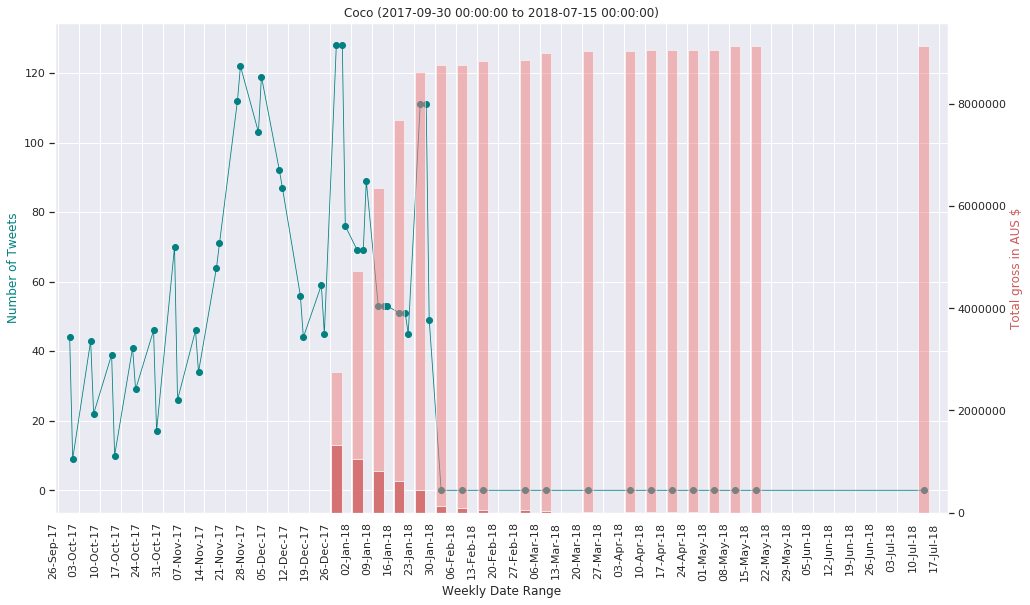

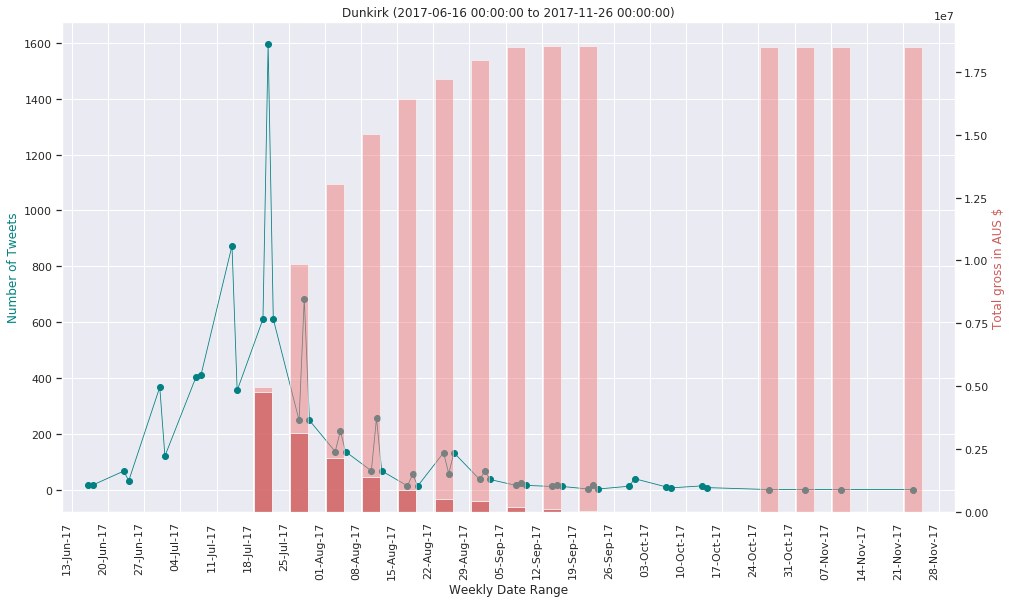

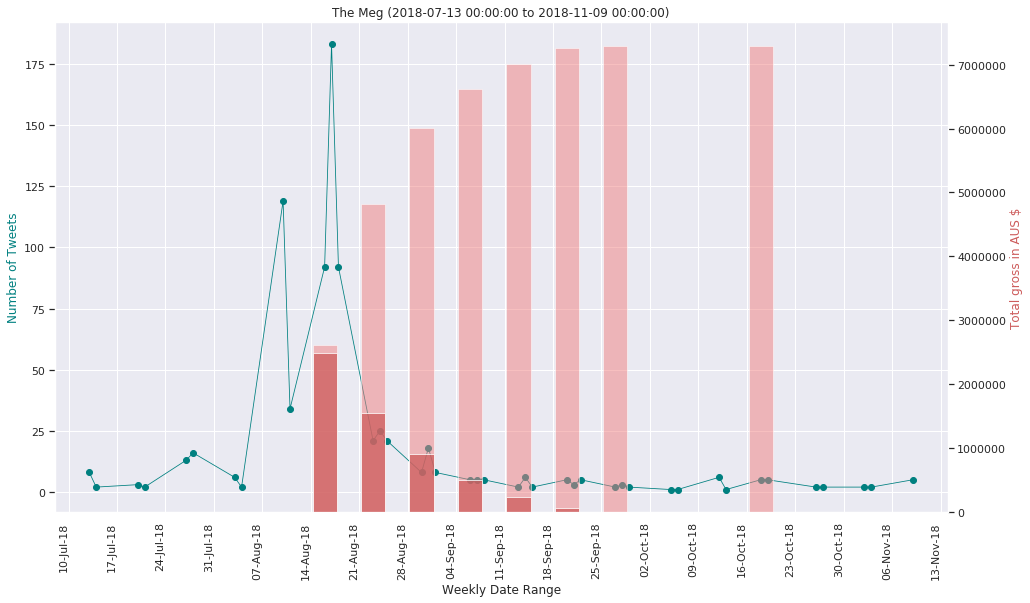

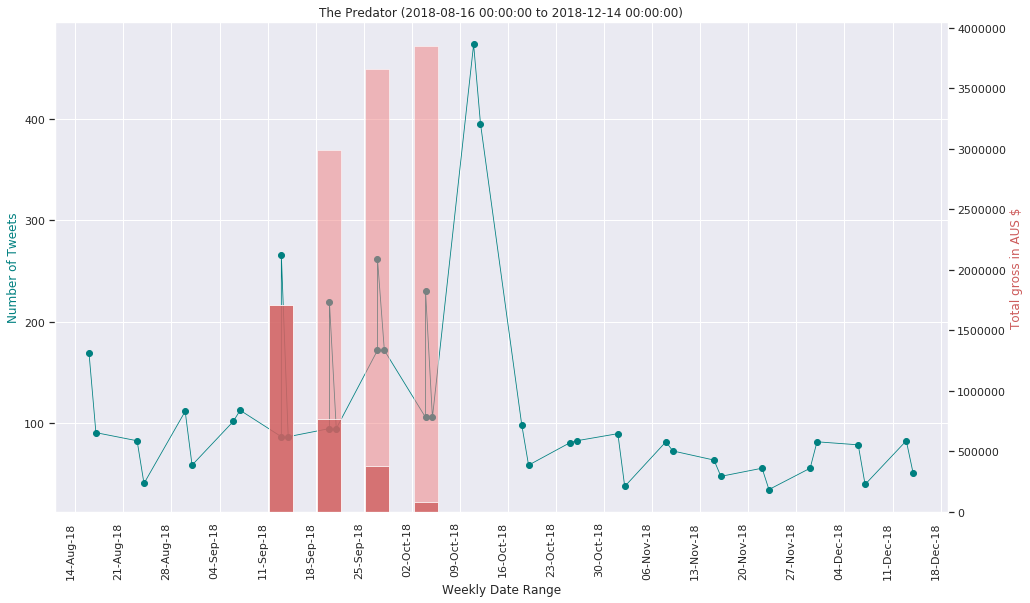

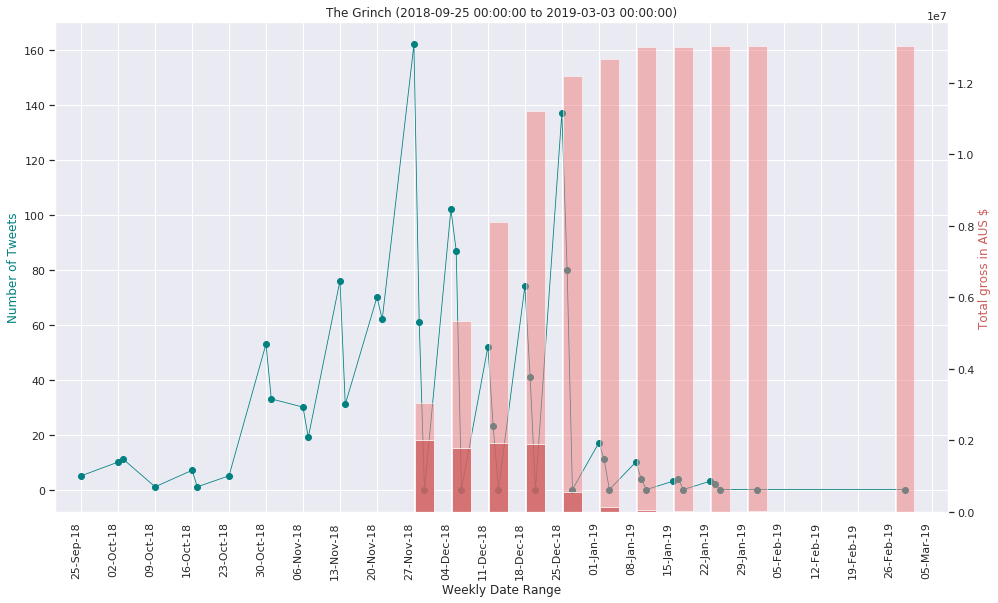

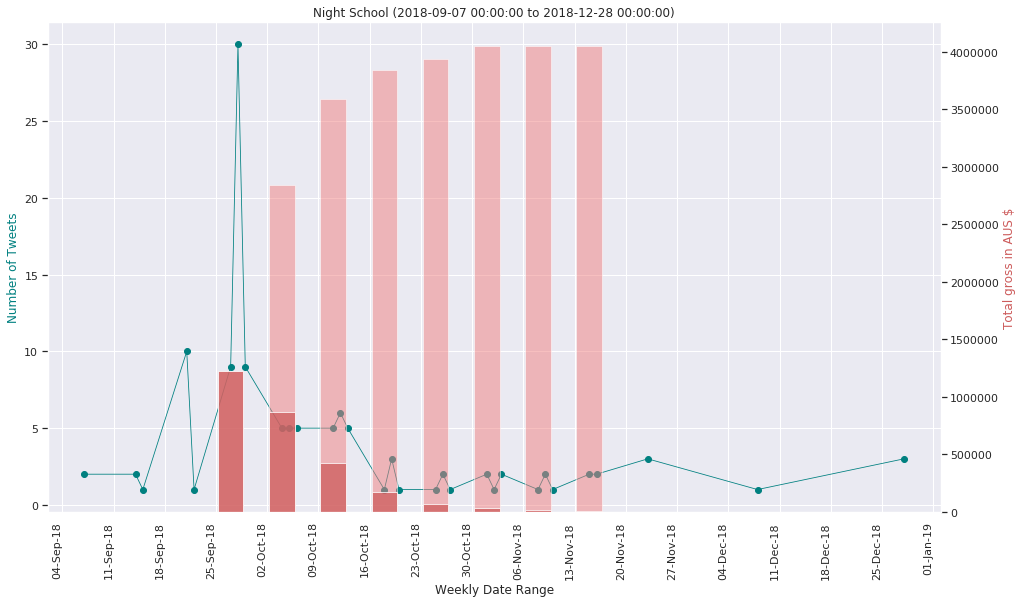

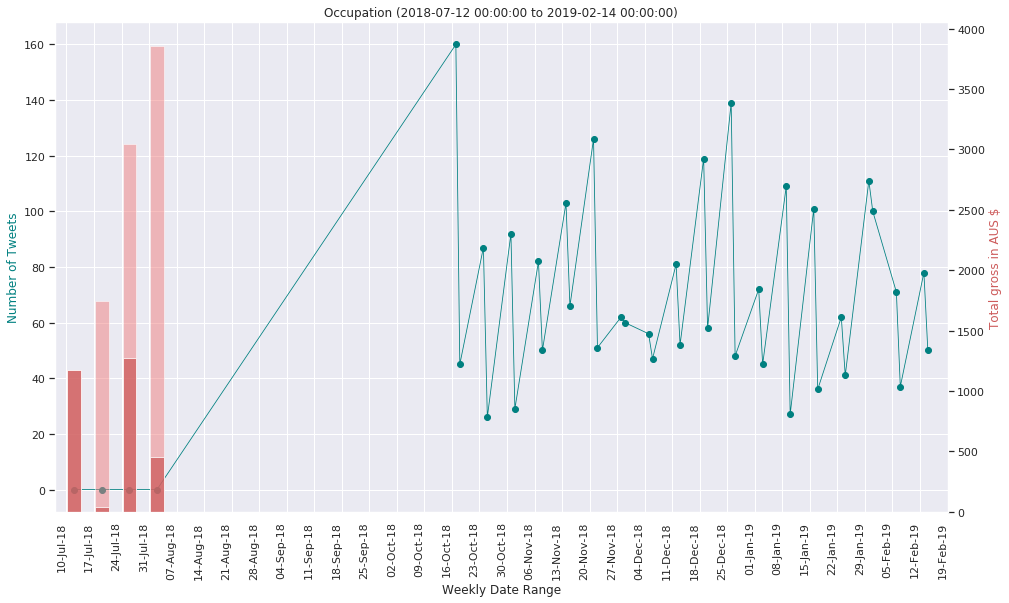

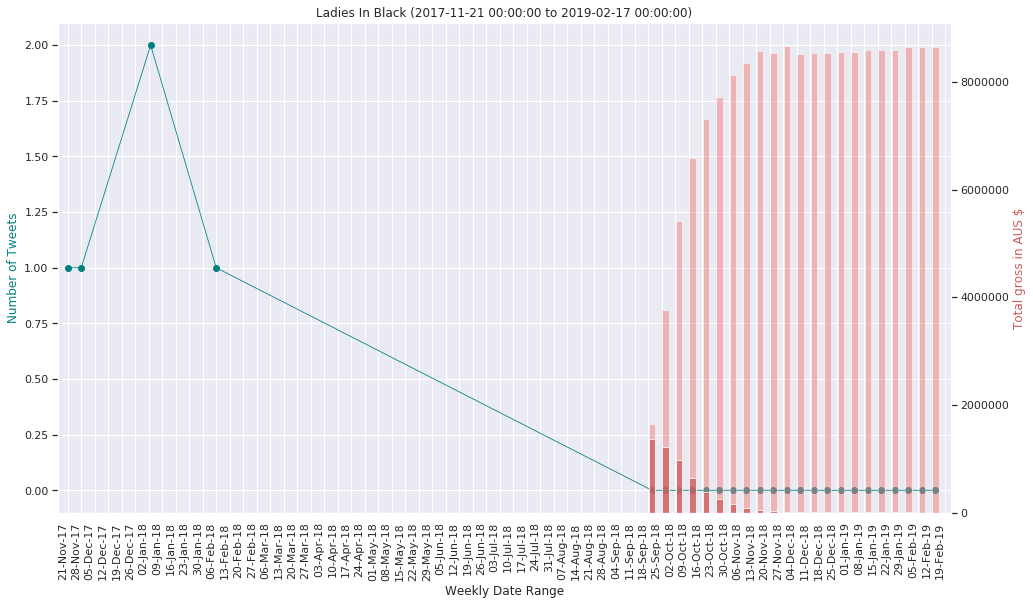

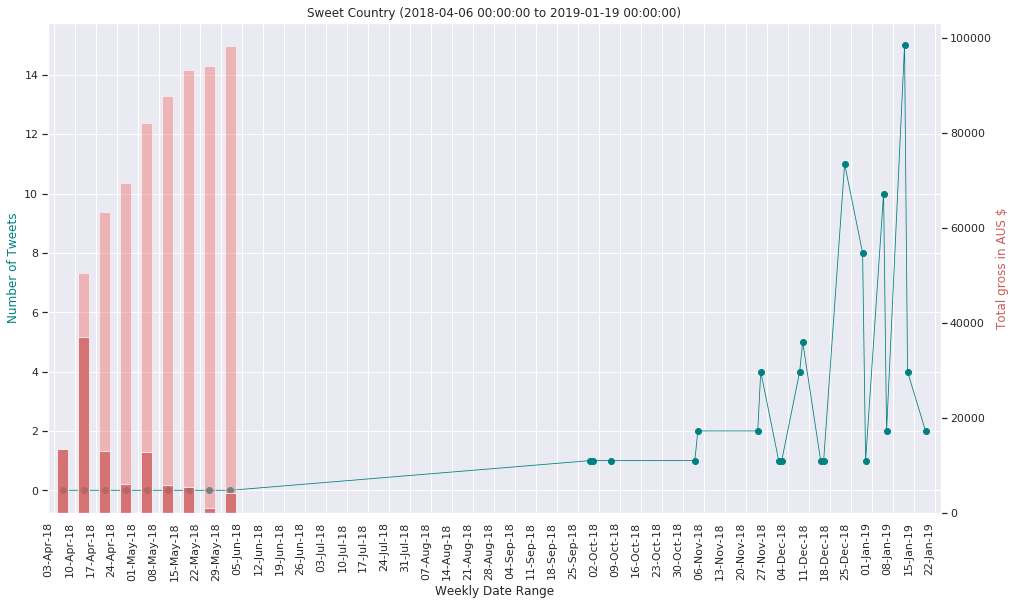

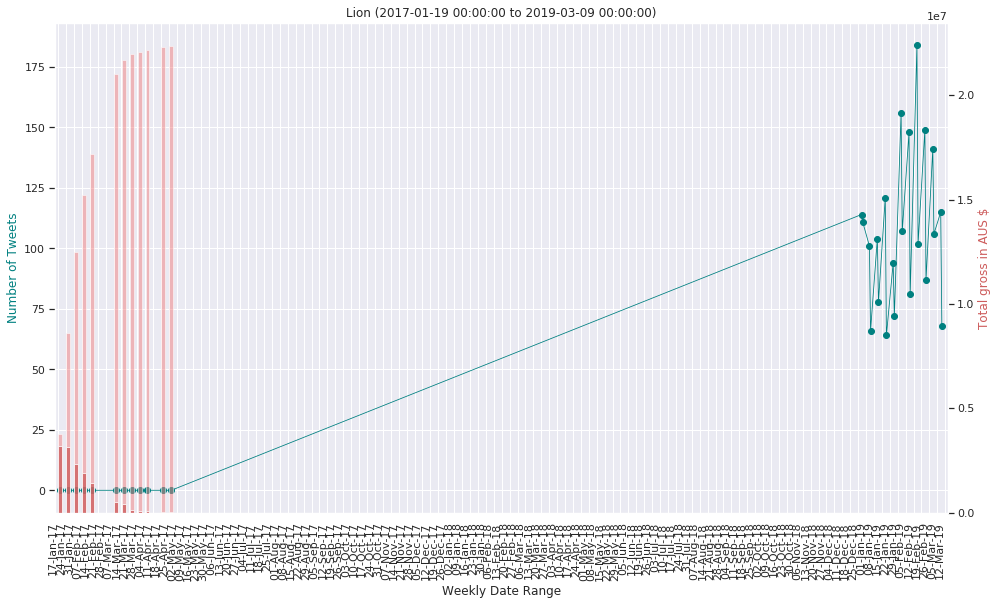

In [26]:
for group in box_vs_tweets.groupby(['movie_id_t']):
    
    # plot for each movie individually
    # change plotting visual style.
    
    date_form = DateFormatter("%d-%b-%y")
    
    mini = group[1]
    start_date_lim = mini['begin_date'].iloc[0] - datetime.timedelta(days=5)
    end_date_lim = mini['end_date'].iloc[len(mini)-1] + datetime.timedelta(days=5)

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    
    ax1.set_title("{} ({} to {})".format(string.capwords(mini['Title'].iloc[0]), mini['begin_date'].iloc[0], mini['end_date'].iloc[len(mini)-1]))
    ax1.plot(mini['begin_date'], mini['tweets_received'], color="teal", marker="o", linewidth=0.8)
    ax1.set_ylabel("Number of Tweets")
    ax1.yaxis.label.set_color('teal')

    ax2 = ax1.twinx()
    ax2.bar(x=mini['begin_date'], height=mini['gross_to_date_float'], width=3.5, alpha=0.5, color="lightcoral")
    ax2.bar(x=mini['begin_date'], height=mini['weekend_gross_float'], width=3.5, alpha=0.75, color="indianred")
    ax2.set_ylabel("Total gross in AUS $")
    ax2.yaxis.label.set_color('indianred')
    ax2.grid(False)

    ax1.set_xlabel("Weekly Date Range")

    # Define the date format
    fig.autofmt_xdate(rotation=90)

    ax1.set_xlim([start_date_lim, end_date_lim])

    ax1.xaxis.set_major_formatter(date_form)
    ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

### Sentiment of tweets

In [31]:
sub = df_sbuzz[['movie_id_s', 'title', 'post_date', 'tweet_sentiment']]

In [32]:
# print(stats.mode(sub['tweet_sentiment']).mode)
# print(np.mean(sub['tweet_sentiment']))
# print(np.median(sub['tweet_sentiment']))

In [33]:
# mini = sub.groupby(['movie_id_s', 'title', 'post_date'])['tweet_sentiment'].agg(pd.Series.mode).unstack(1)
mini = sub.groupby(['movie_id_s', 'title', 'post_date'])['tweet_sentiment'].mean().unstack(1)

In [34]:
# mini

In [35]:
box_vs_sentiment = df_title[['movie_id_t', 'Title', 'Week # of release','begin_date', 'end_date', 'gross_to_date_float', 'weekend_gross_float']]

In [36]:
box_vs_sentiment['tweet_sentiment'] = 0

In [37]:
for m_id, time in mini.index:
    curr_df = box_vs_sentiment[box_vs_sentiment['movie_id_t']==m_id]
    for idx in curr_df.index:
        
        if curr_df.at[idx, 'begin_date'] < time < curr_df.at[idx, 'end_date']:
            box_vs_sentiment.at[idx, 'tweet_sentiment'] = np.mean(mini.loc[(m_id, time), rev_movie_dict[m_id]])

        if curr_df.at[idx, 'begin_date'] > time or curr_df.at[idx, 'begin_date'] < time:
            new_idx = len(box_vs_sentiment)+1
            box_vs_sentiment.at[new_idx, 'begin_date'] = time.date()
            box_vs_sentiment.at[new_idx, 'end_date'] = time.date()
            box_vs_sentiment.at[new_idx, 'Title'] = rev_movie_dict[m_id]
            box_vs_sentiment.at[new_idx, 'movie_id_t'] = m_id
            box_vs_sentiment.at[new_idx, 'tweet_sentiment'] = np.mean(mini.loc[(m_id, time), rev_movie_dict[m_id]])
        
    box_vs_sentiment.drop_duplicates(inplace=True)

In [38]:
box_vs_sentiment = (box_vs_sentiment
                 .sort_values(by=['movie_id_t', 'begin_date'])
                 .reset_index()
                 .drop(axis=1, labels=['index'])
                 .fillna(0))

In [39]:
box_vs_sentiment["rel_week_release"] = 0

for key in set_intersection_titles:
    d = box_vs_sentiment[box_vs_sentiment['movie_id_t']==key]
    
    # assuming first starts with 1st week of release by default

    indicator = 1
    first = list(d[d['Week # of release']==indicator]['begin_date'])[0]

    for ix in d.index:
        
        if d.at[ix, 'rel_week_release'] == 0:
                        
            if d.at[ix, 'begin_date'] == first:
                box_vs_sentiment.at[ix, 'rel_week_release'] =  indicator

            elif d.at[ix, 'begin_date'] < first:
                delta_days = d.at[ix, 'begin_date'] - first
                box_vs_sentiment.at[ix, 'rel_week_release'] =  (delta_days/7).days 

            elif d.at[ix, 'begin_date'] > first:
                delta_days = d.at[ix, 'begin_date'] - first
                box_vs_sentiment.at[ix, 'rel_week_release'] =  (delta_days/7).days + 1

In [40]:
# box_vs_sentiment

In [42]:
bvs2 = box_vs_sentiment.drop(axis=1, labels=['Week # of release', 'begin_date', 'end_date'])

In [43]:
ff2 = (bvs2.groupby(['Title', 'rel_week_release'])['tweet_sentiment'].mean().unstack(-1))

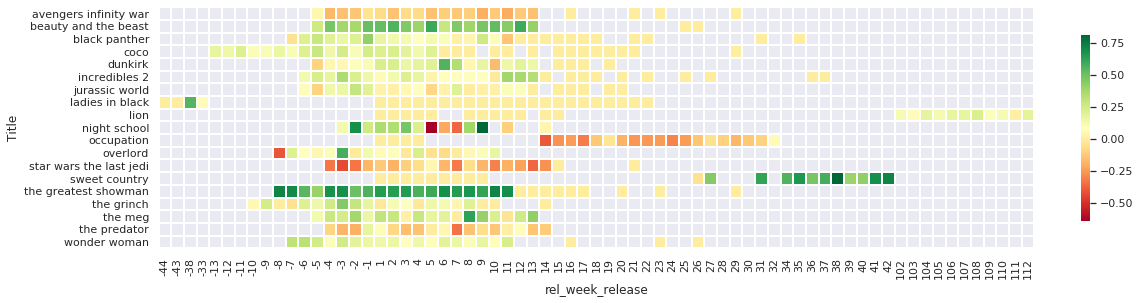

In [44]:
# sentiments varying as weeks progress in the box office
hgf = sns.heatmap(
    ff2, 
    square=True, 
    cbar_kws={'fraction' : 0.01}, 
    cmap='RdYlGn',
    linewidth=1 
);
plt.tight_layout()

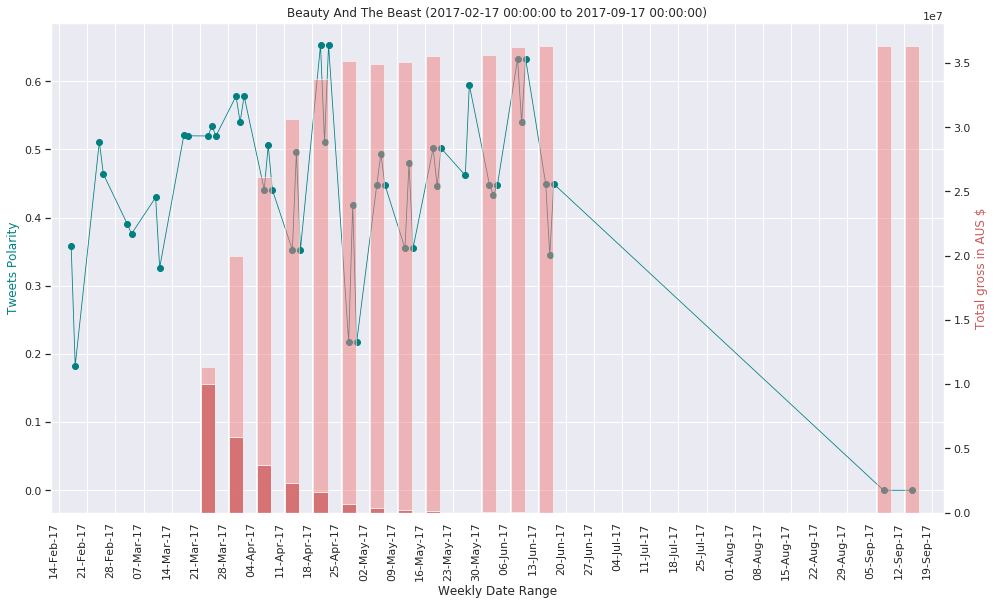

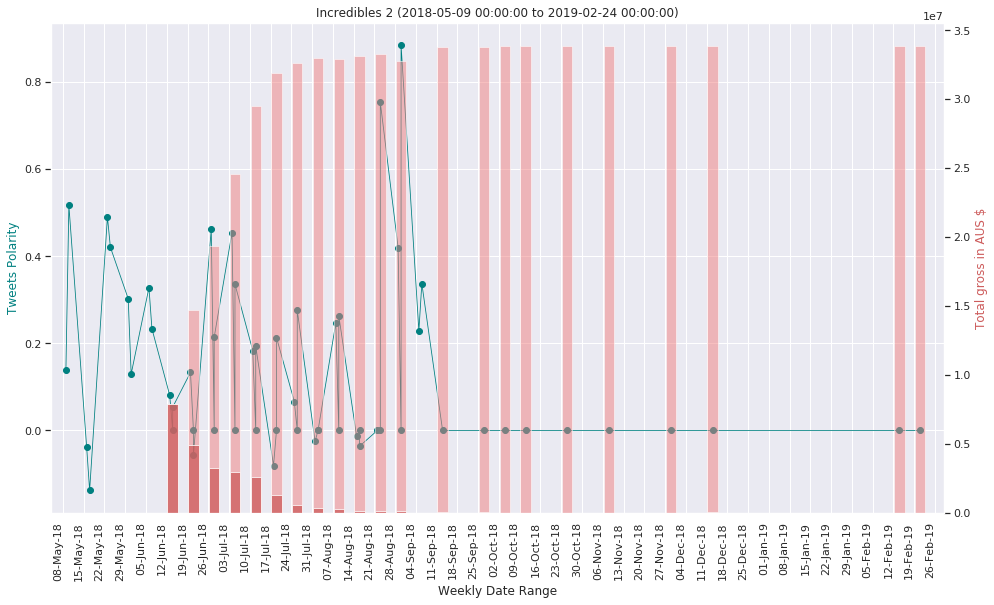

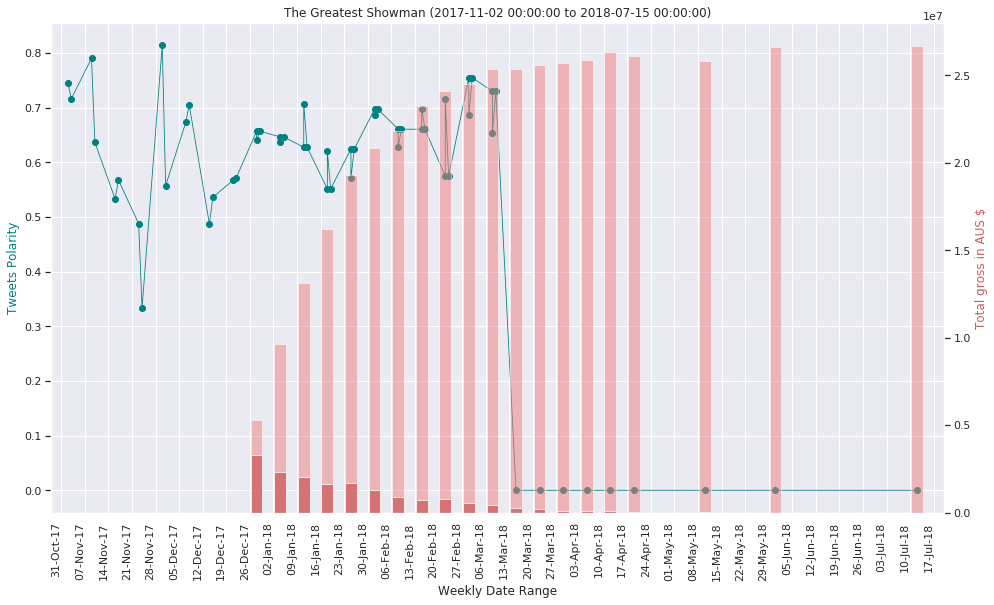

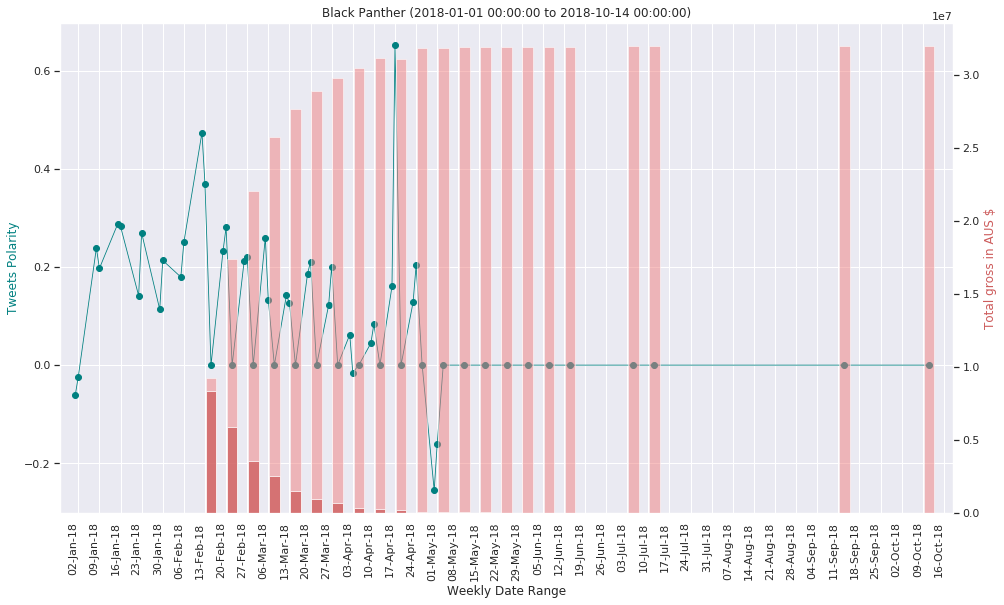

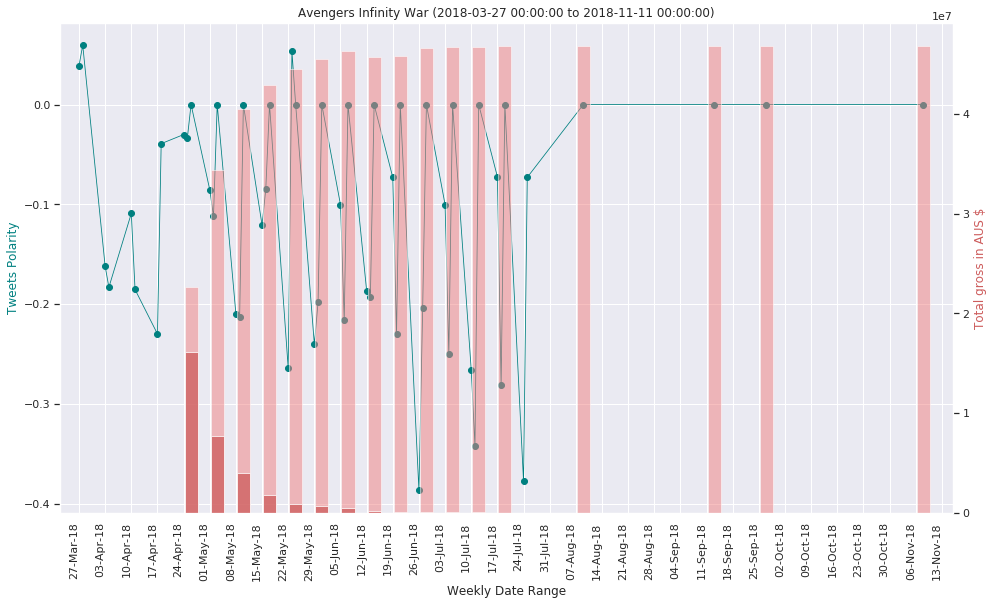

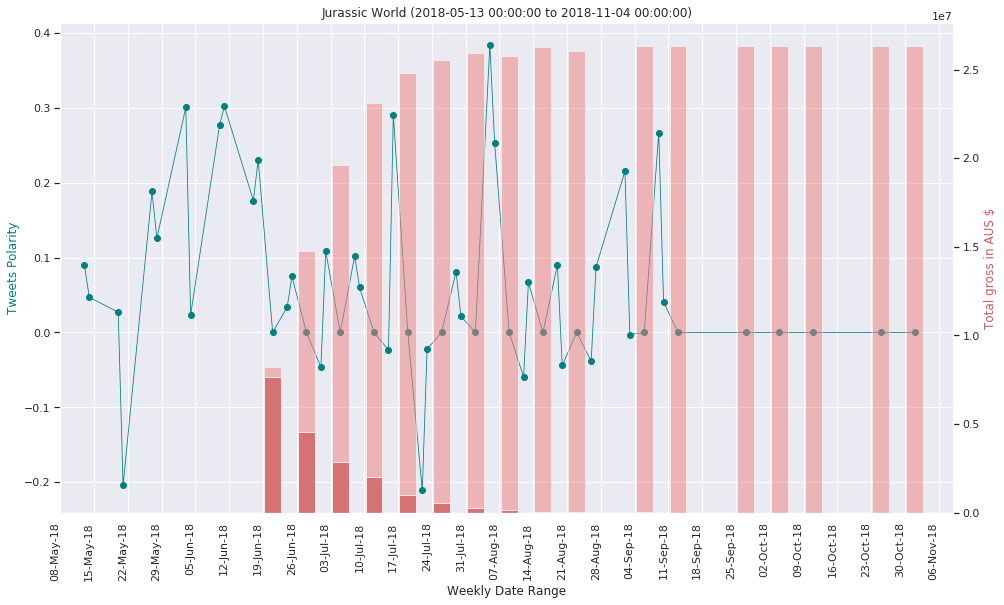

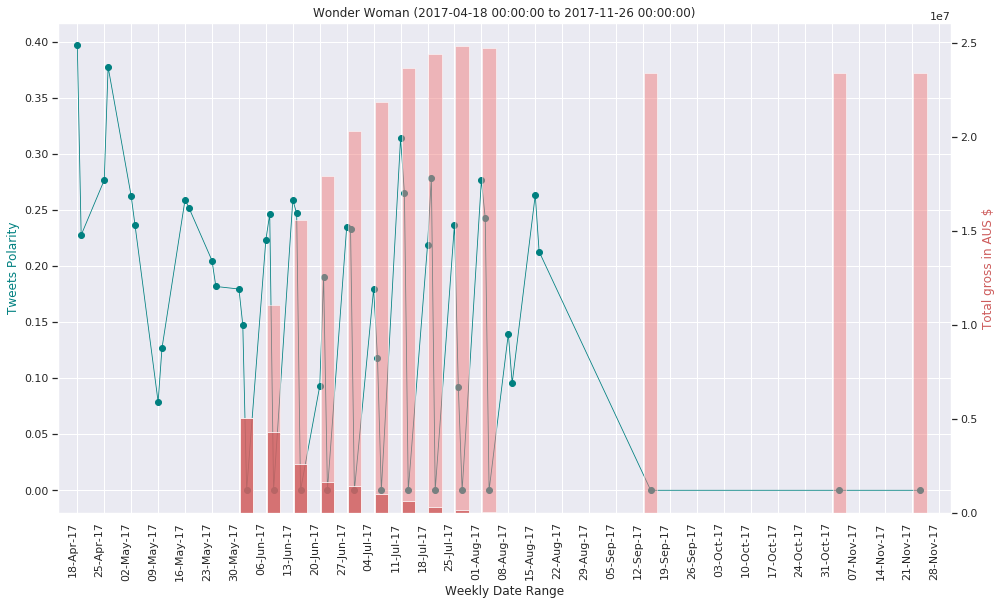

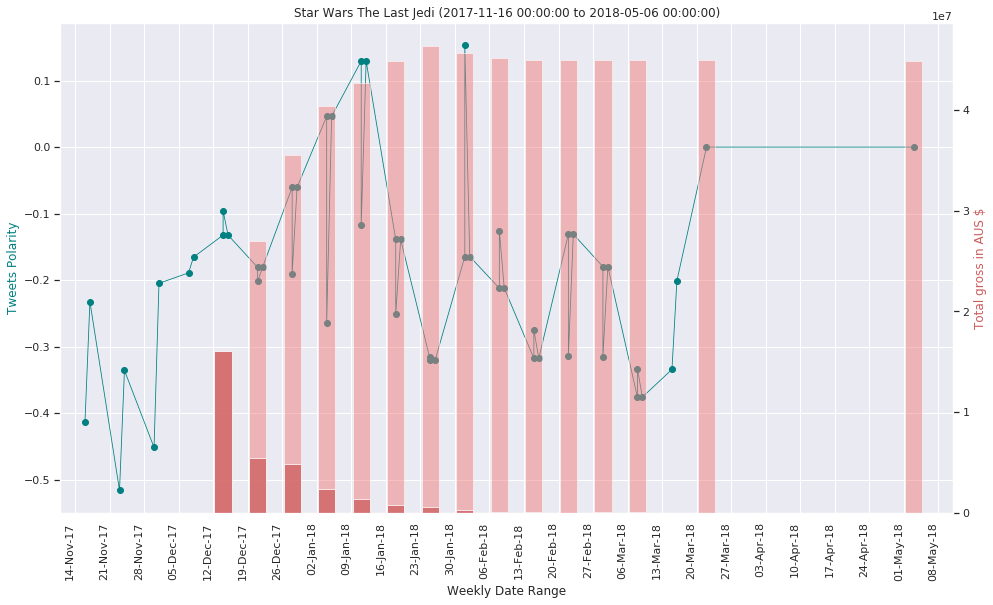

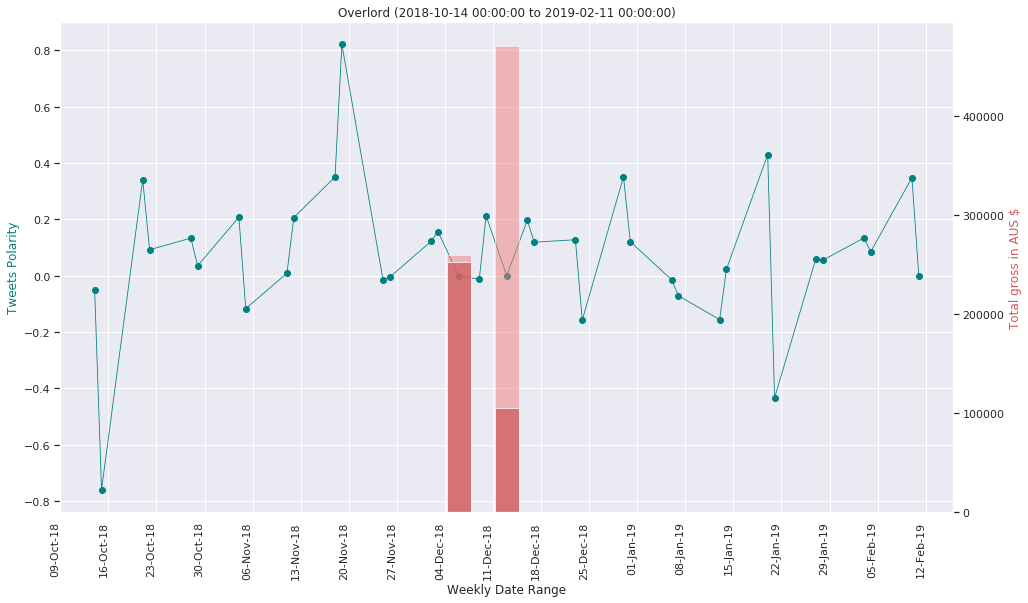

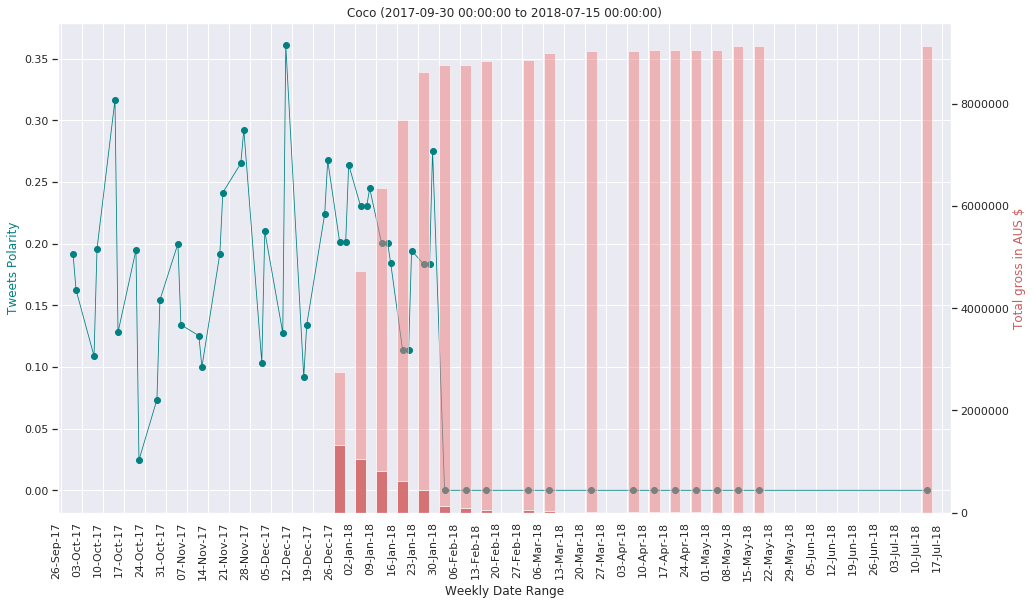

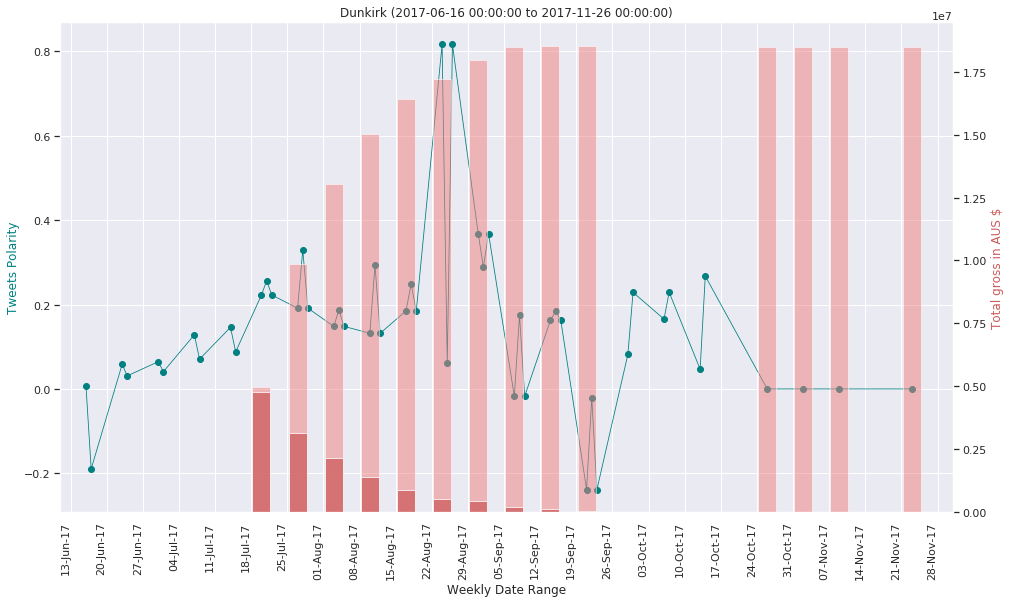

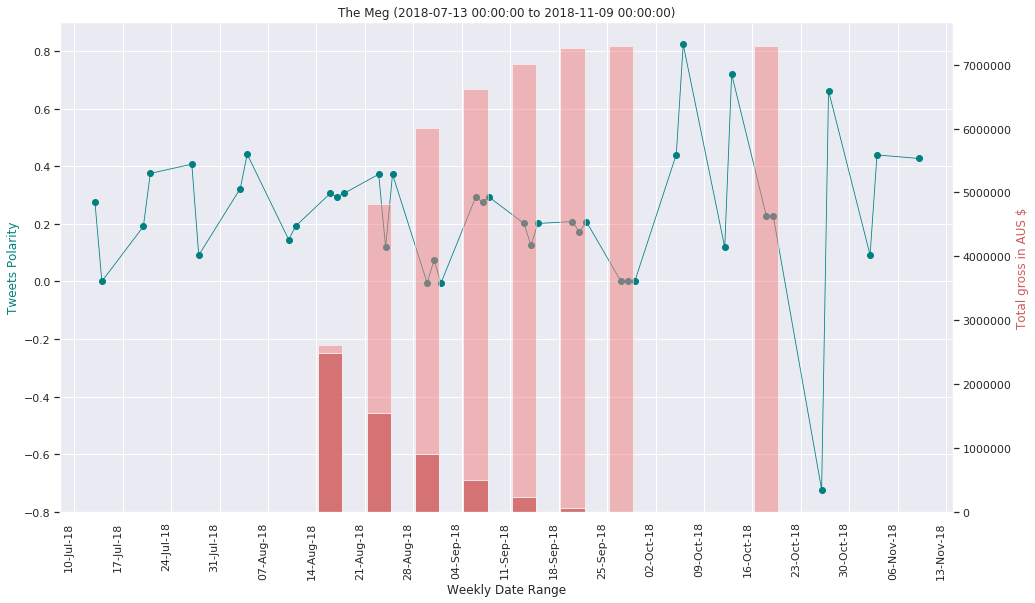

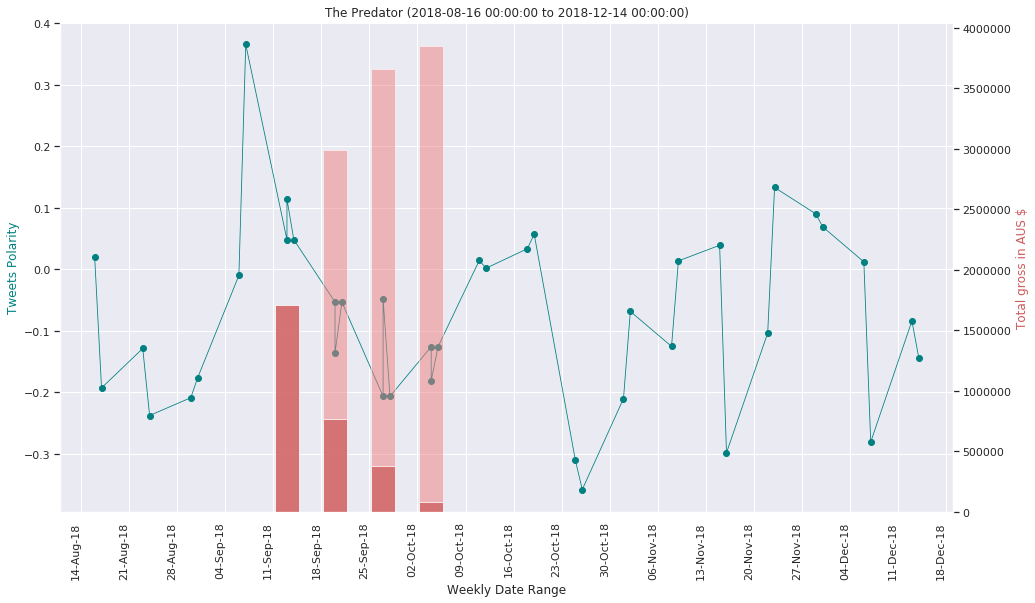

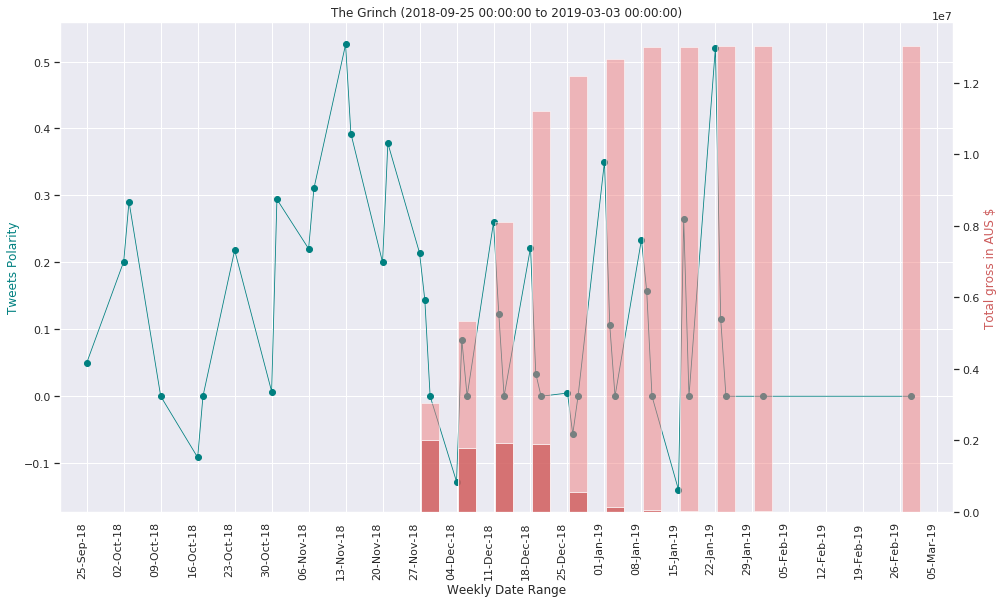

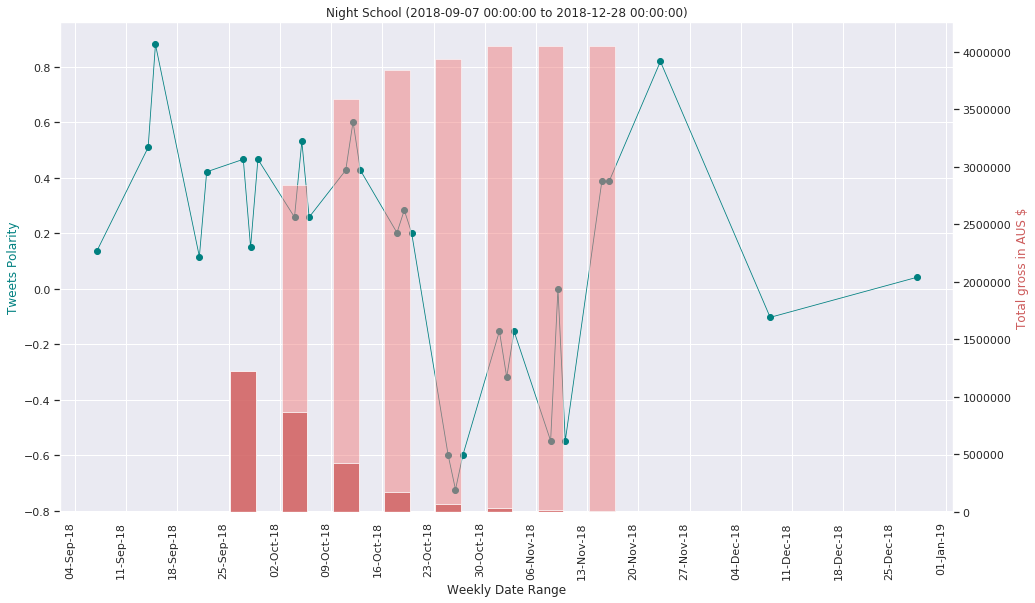

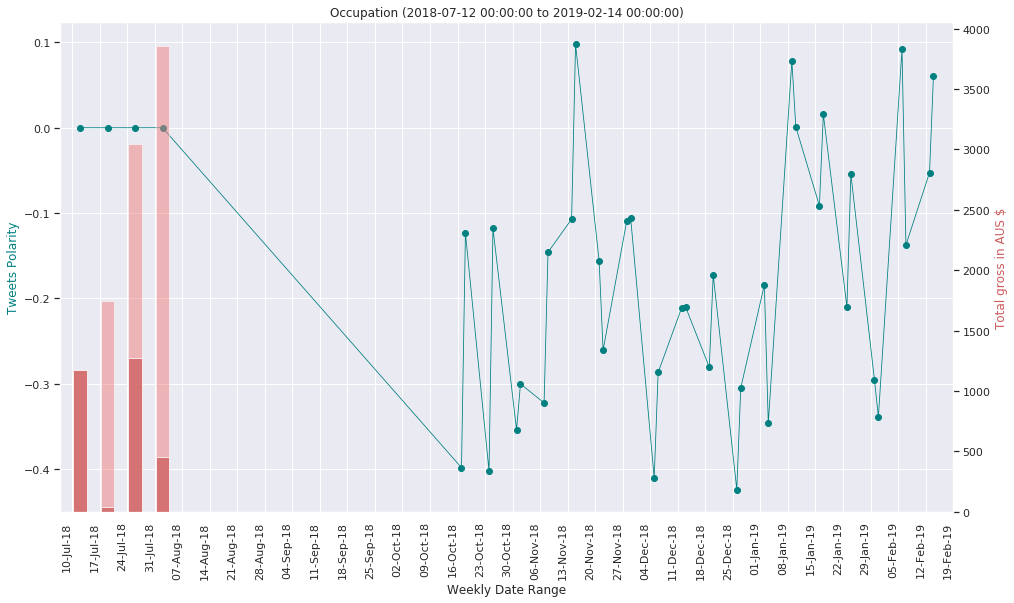

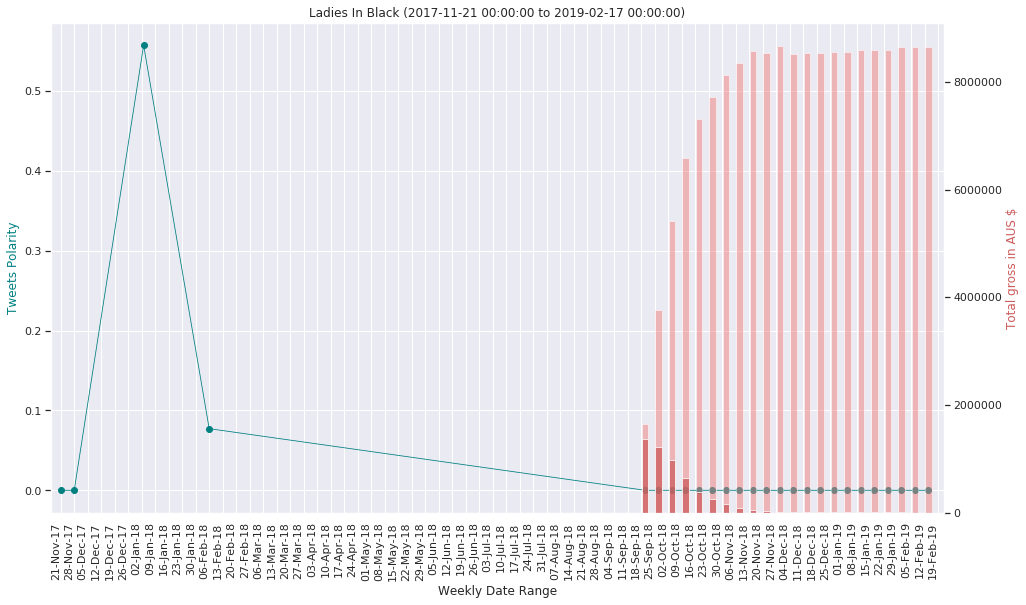

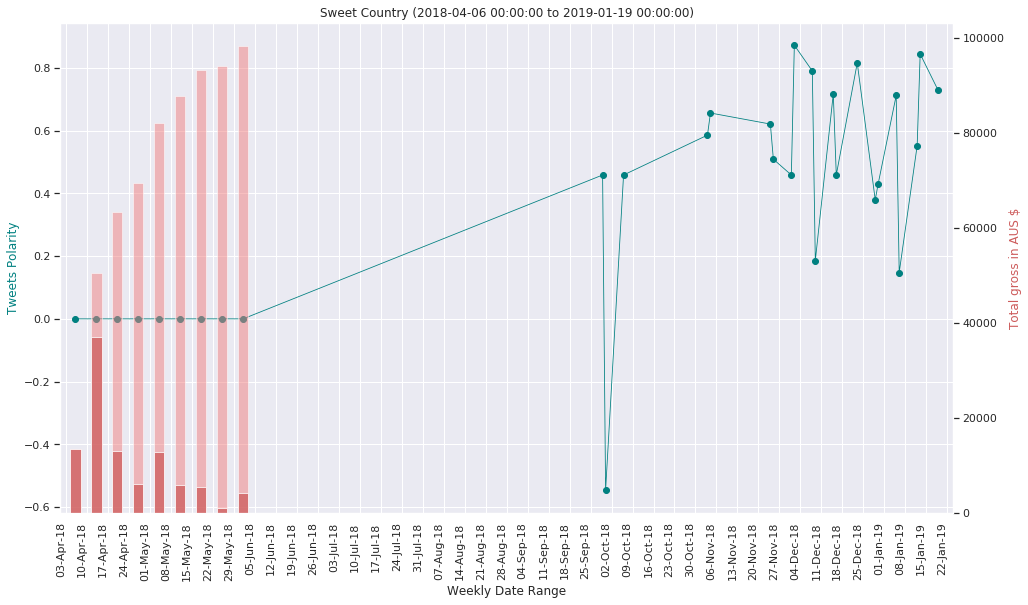

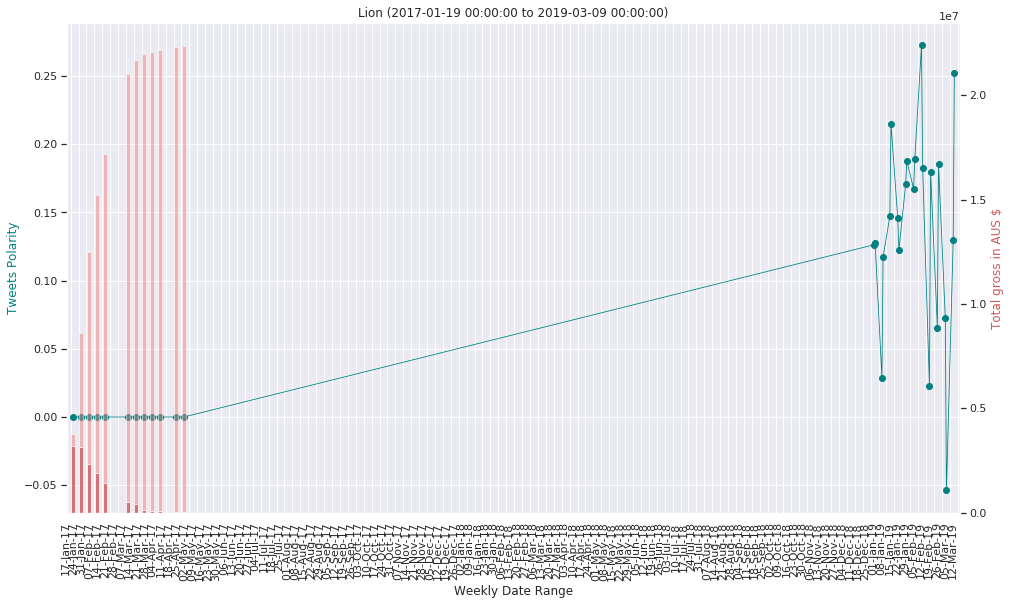

In [41]:
for group in box_vs_sentiment.groupby(['movie_id_t']):
    
    # plot for each movie individually
    # change plotting visual style.
    
    date_form = DateFormatter("%d-%b-%y")
    
    mini = group[1]
    start_date_lim = mini['begin_date'].iloc[0] - datetime.timedelta(days=5)
    end_date_lim = mini['end_date'].iloc[len(mini)-1] + datetime.timedelta(days=5)

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    
    ax1.set_title("{} ({} to {})".format(string.capwords(mini['Title'].iloc[0]), mini['begin_date'].iloc[0], mini['end_date'].iloc[len(mini)-1]))
    ax1.plot(mini['begin_date'], mini['tweet_sentiment'], color="teal", marker="o", linewidth=0.8)
    ax1.set_ylabel("Tweets Polarity")
    ax1.yaxis.label.set_color('teal')

    ax2 = ax1.twinx()
    ax2.bar(x=mini['begin_date'], height=mini['gross_to_date_float'], width=3.5, alpha=0.5, color="lightcoral")
    ax2.bar(x=mini['begin_date'], height=mini['weekend_gross_float'], width=3.5, alpha=0.75, color="indianred")
    ax2.set_ylabel("Total gross in AUS $")
    ax2.yaxis.label.set_color('indianred')
    ax2.grid(False)

    ax1.set_xlabel("Weekly Date Range")

    # Define the date format
    fig.autofmt_xdate(rotation=90)

    ax1.set_xlim([start_date_lim, end_date_lim])

    ax1.xaxis.set_major_formatter(date_form)
    ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

### Seasonality/Genre/Influencer effecting sales

#### Seasonality

In [45]:
# perform same heatmap analysis for nth week of the year sales - to get idea about seasonality

by_nth_week = (df_title
              .groupby(['Title', 'nth_week_number'])
              .size()
              .unstack())

for idx in by_nth_week.index:
    for col in by_nth_week.columns:
        
        try:
            by_nth_week.at[idx, col] = float(df_title[(df_title['Title']==idx) & (df_title['nth_week_number']==col)]['gross_to_date_float'])
        except:
            by_nth_week.at[idx, col] = np.nan

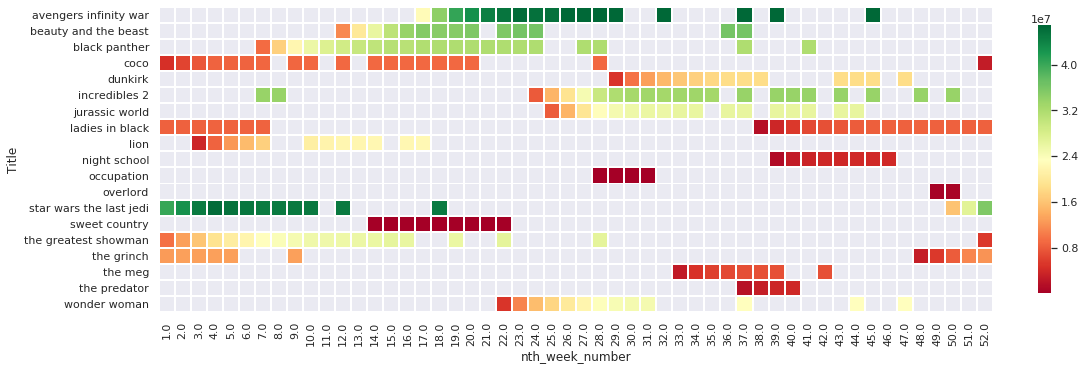

In [46]:
nth_week_releases = sns.heatmap(
    by_nth_week, 
    square=True, 
    cbar_kws={'fraction' : 0.015}, 
    cmap='RdYlGn',
    linewidth=1 
)

#### Influencer

In [47]:
followers_freq = df_sbuzz['user_followers_count'].value_counts(sort=True, ascending=True).to_dict()

In [48]:
max(followers_freq)

10883460

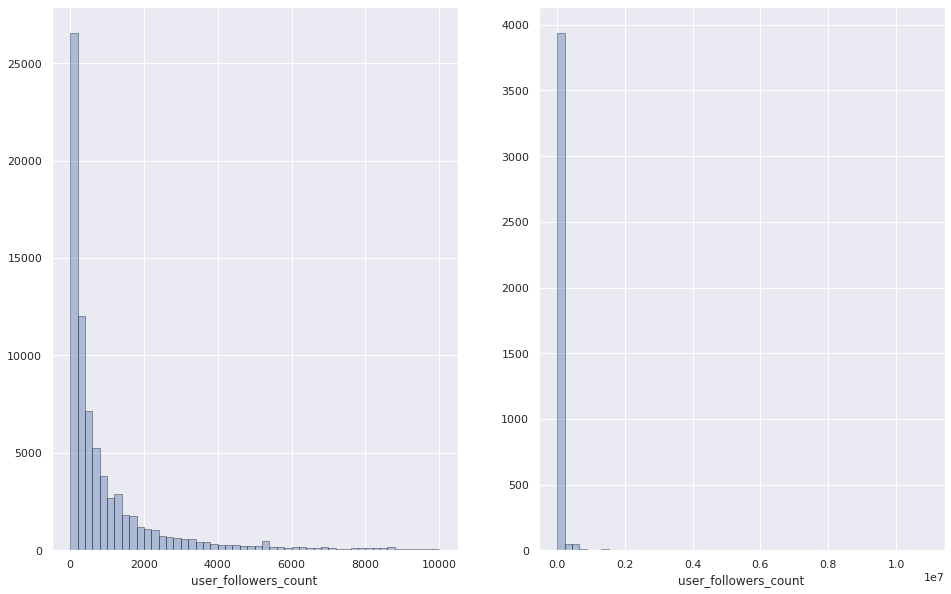

In [49]:
plt.subplot(1, 2, 1)
sns.distplot(df_sbuzz['user_followers_count'][df_sbuzz['is_influencer']==False], kde=False, hist_kws=dict(edgecolor="k"));
plt.subplot(1, 2, 2)
sns.distplot(df_sbuzz['user_followers_count'][df_sbuzz['is_influencer']==True], kde=False, hist_kws=dict(edgecolor="k"));

# there are some outliers with influencer followers count

### Any time series studies?

------------------------------------------------------------------